## Exploratory Data Analysis
This notebook consists of the exploratory data analysis step in our project previous the migration of data to the database.
The goal in this notebook is to explore the zomato dataset with visualizations, finding NaN and duplicates values, and describing
the data types that will be useful when creating our tables in MySQL.


In [1]:
# Geopandas packages help us to create visualizations using coordinates.
!pip install geopandas

In [59]:
# Import libraries to Explore data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from itertools import chain
# We installed GeoPandas to create a visualization of restaurant's coordinates
from shapely.geometry import Point
import geopandas as gpd 
from geopandas import GeoDataFrame

plt.style.use('seaborn')

In [4]:
data = pd.read_csv('zomato.csv', encoding = 'latin1')
data.head(3)

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270


In [26]:
#This dataset has a dimension of 21 columns x 9551 rows,
# however we will have to check for duplicates and NaN
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 21 columns):
Restaurant ID           9551 non-null int64
Restaurant Name         9551 non-null object
Country Code            9551 non-null int64
City                    9551 non-null object
Address                 9551 non-null object
Locality                9551 non-null object
Locality Verbose        9551 non-null object
Longitude               9551 non-null float64
Latitude                9551 non-null float64
Cuisines                9542 non-null object
Average Cost for two    9551 non-null int64
Currency                9551 non-null object
Has Table booking       9551 non-null object
Has Online delivery     9551 non-null object
Is delivering now       9551 non-null object
Switch to order menu    9551 non-null object
Price range             9551 non-null int64
Aggregate rating        9551 non-null float64
Rating color            9551 non-null object
Rating text             9551 non-null o

In [5]:
# Apparently this dataset does not contain null values,
# however we will apply dropna() and see how its shape changes
print('Shape before dropna:', data.shape)
data.dropna(inplace=True)
print('Shape after dropna:', data.shape)

Shape before dropna: (9551, 21)
Shape after dropna: (9542, 21)


In [6]:
## Find duplicates in data, and explore the Restaurant Name, Restaurant ID, and Cuisine columns:
cuisines = data.Cuisines.value_counts().to_dict()
restaurants = data['Restaurant Name'].value_counts().to_dict().keys()
restaurants_id= data['Restaurant ID'].value_counts().to_dict().keys()

# We can see that we have some restaurants that belongs to the category of 'Chains'.
#for instance 'Dunikin Donuts'. So, we will have duplicates in the Restaurant Name column. 
print('The number of different restaurants:', len(list(restaurants)))
print('The number of different restaurant ids:', len(list(restaurants_id)))

# We also see that the Cuisine column contains lists of the different types of cuisines 
# that each restaurant prepares. For example, 
#['indian', 'chinese', 'filipino']. This information is will be decomposed in new rows
print('Example of one cell in the Cuisines column: ',random.choice(list(cuisines.keys())))

The number of different restaurants: 7437
The number of different restaurant ids: 9542
Example of one cell in the Cuisines column:  North Indian, Fast Food, Italian, Asian


In [7]:
# We couldn't find any duplicate in the Restuarant ID column, and that is good news.
# Eventhough some resturants like 'chain restaurants' share the same name, their IDs are
# different. Therefore, we can use this column as a Primary Key in MySQL table creation notebook
duplicate = data[data.duplicated('Restaurant ID')] 
print("Duplicate Rows based on Restaurant ID :") 
# Print the resultant Dataframe
duplicate.shape

Duplicate Rows based on Restaurant ID :


(0, 21)

In [75]:
# Let's explore the currency column. To our understanding we need to map this currencies
# to US dollars.
data['Currency'].value_counts()

Indian Rupees(Rs.)        8652
Dollar($)                  473
Pounds(£)                  80
Emirati Diram(AED)          60
Brazilian Real(R$)          60
Rand(R)                     60
NewZealand($)               40
Turkish Lira(TL)            34
Botswana Pula(P)            22
Indonesian Rupiah(IDR)      21
Sri Lankan Rupee(LKR)       20
Qatari Rial(QR)             20
Name: Currency, dtype: int64

In [9]:
# To convert to US Dollars, we created a the next function:
def currency (row):
    """ This function takes a row of the dataframe as input
    and returns the a new value of 'Average Cost for two'
    in Dollars when 'Currency' column is not dollars
    """
    if row['Currency'] == 'Indian Rupees(Rs.)':
        return round(row['Average Cost for two']*0.013, 2)
    if row['Currency'] == 'Dollar($)':
        return row['Average Cost for two']
    if row['Currency'] == ('Pounds(£)'):
        return round(row['Average Cost for two']*1.37, 2)
    if row['Currency'] == 'Rand(R)':
        return round(row['Average Cost for two']*0.068, 2)
    if row['Currency'] == 'Emirati Diram(AED)':
        return round(row['Average Cost for two']*0.27, 2)
    if row['Currency'] == 'Brazilian Real(R$)':
        return round(row['Average Cost for two']*0.18, 2)
    if row['Currency'] == 'NewZealand($)':
        return round(row['Average Cost for two']*0.70, 2)
    if row['Currency'] == 'Turkish Lira(TL)':
        return round(row['Average Cost for two']*0.12, 2)
    if row['Currency'] == 'Botswana Pula(P)':
        return round(row['Average Cost for two']*0.091, 2)
    if row['Currency'] == 'Indonesian Rupiah(IDR)':
        return round(row['Average Cost for two']*0.000069, 2)
    if row['Currency'] == 'Qatari Rial(QR)':
        return round(row['Average Cost for two']*0.27, 2)
    if row['Currency'] == 'Sri Lankan Rupee(LKR)':
        return round(row['Average Cost for two']*0.0050, 2)

# Then, we applied this function for every row in the dataset
data['Average cost USD'] = data.apply (lambda row: currency(row), axis=1)

Number of values = 0 in Average cost USD: 15


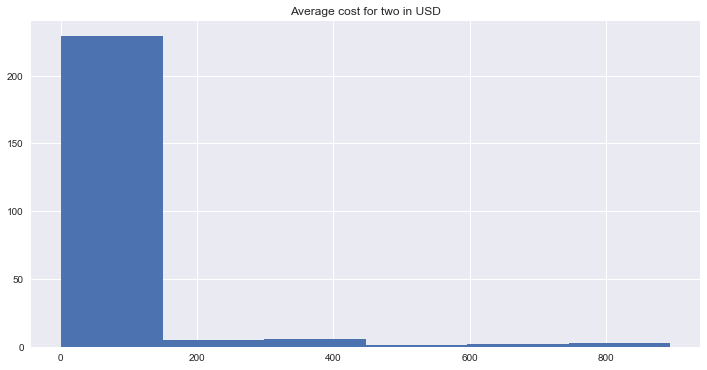

In [76]:
# To have some idea of the Average cost for two column we see that
# we have values equal to zero
data['Average cost USD'].value_counts(sort= False).hist(bins=6, figsize= (12,6))
plt.title('Average cost for two in USD')
# We explored those zero values and find that 15 entries have 0 values:
print('Number of values = 0 in Average cost USD:', data[data['Average cost USD']==0].shape[0])

In [34]:
# We found that locality verbose, and locality columns contain the same information, therefore we should onl
print('Local Verbose:', data['Locality Verbose'][5])
print('Locality:', data['Locality'][5])
print('Address:', data['Address'][5])

## Therefore, for convenience we kept Address and Locality:
data.drop('Locality Verbose', axis=1, inplace=True)

Local Verbose: SM Megamall, Ortigas, Mandaluyong City, Mandaluyong City
Locality: SM Megamall, Ortigas, Mandaluyong City
Address: Ground Floor, Mega Fashion Hall, SM Megamall, Ortigas, Mandaluyong City


Data visualization:

/Users/josegarcia/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/josegarcia/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 140 missing from current font.
  font.set_text(s, 0, flags=flags)


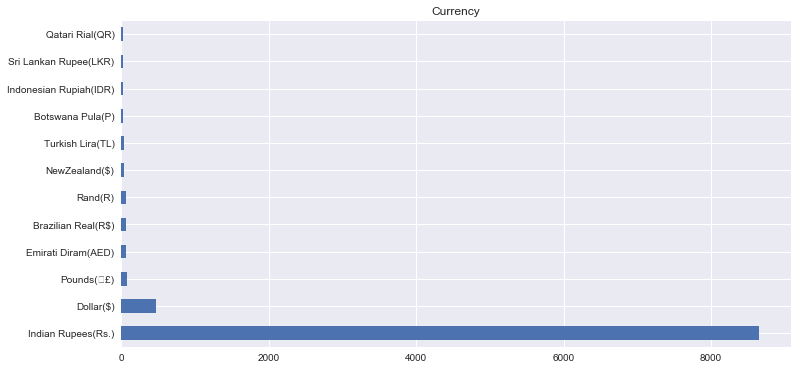

In [61]:
# Visualization of the currencies in our dataset:
data['Currency'].value_counts().plot(kind='barh', figsize=(12,6), title='Currency')


No     8384
Yes    1158
Name: Has Table booking, dtype: int64
No     7091
Yes    2451
Name: Has Online delivery, dtype: int64
No     9508
Yes      34
Name: Is delivering now, dtype: int64
No    9542
Name: Switch to order menu, dtype: int64


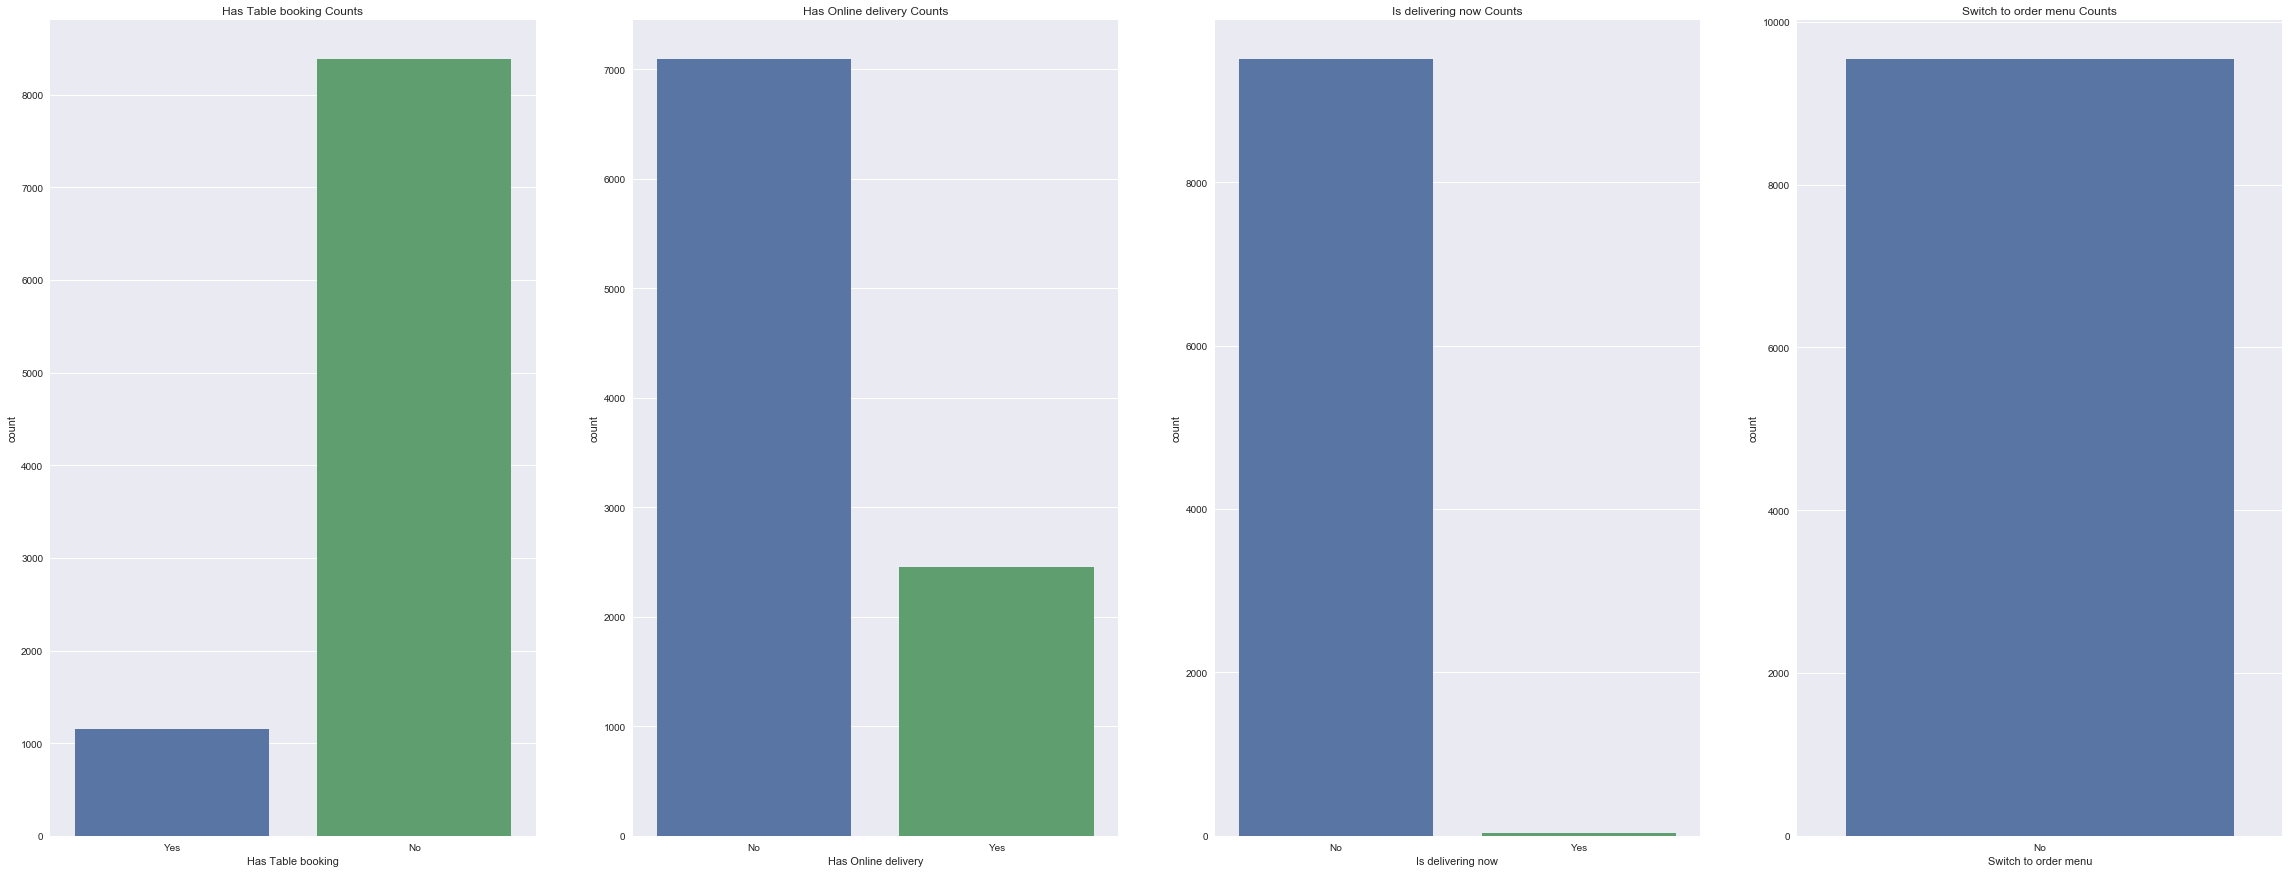

In [78]:
# Next we explored Switch to order menu, Has table booking, and Online Delivery columns:
fig, ax = plt.subplots(1, 4, figsize = (40, 15))
sns.countplot(x = 'Has Table booking', data=data, ax = ax[0]);
print(data['Has Table booking'].value_counts())
ax[0].set_title('Has Table booking Counts');

sns.countplot(x = 'Has Online delivery', data=data, ax = ax[1]);
print(data['Has Online delivery'].value_counts())
ax[1].set_title('Has Online delivery Counts');

sns.countplot(x = 'Is delivering now', data=data, ax = ax[2]);
print(data['Is delivering now'].value_counts())
ax[2].set_title('Is delivering now Counts');

sns.countplot(x = 'Switch to order menu', data=data, ax = ax[3]);
print(data['Switch to order menu'].value_counts())
ax[3].set_title('Switch to order menu Counts');

1    4438
2    3113
3    1405
4     586
Name: Price range, dtype: int64


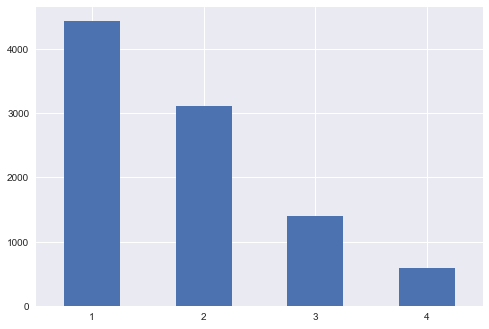

In [63]:
# Price range column:
print(data['Price range'].value_counts())
data['Price range'].value_counts().plot(kind='bar', rot=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text xticklabel objects>)

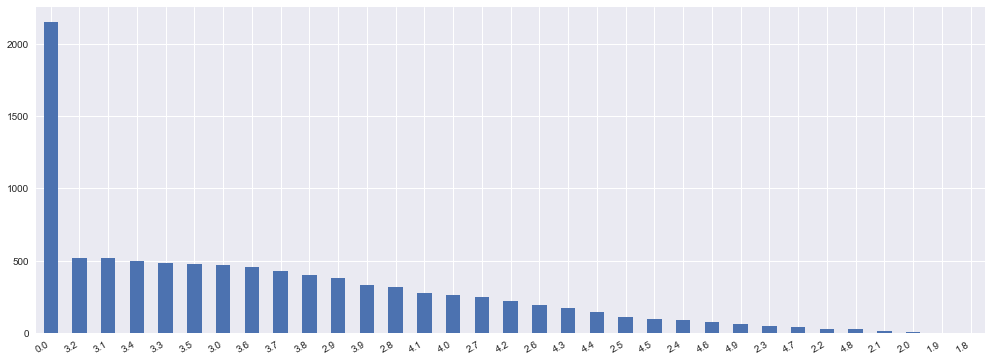

In [64]:
# Aggregate rating:
data['Aggregate rating'].value_counts()
data['Aggregate rating'].value_counts().plot(kind='bar', figsize=(17, 6))
plt.xticks(rotation=30, ha='right')

Orange        3734
White         2148
Yellow        2096
Green         1078
Dark Green     300
Red            186
Name: Rating color, dtype: int64


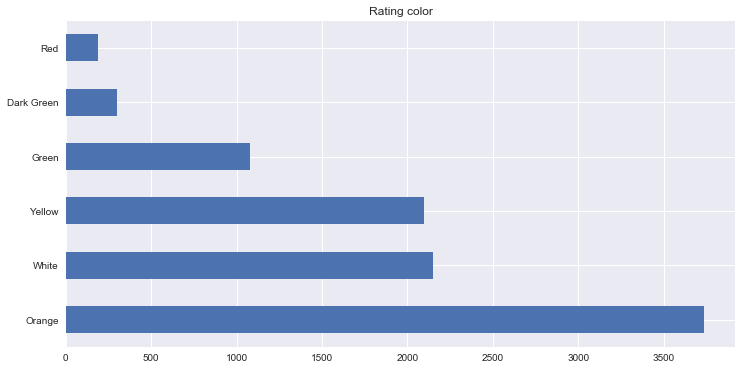

In [65]:
# We are getting to the end, I promise!!
print(data['Rating color'].value_counts())
data['Rating color'].value_counts().plot(kind='barh', figsize=(12,6), title='Rating color')

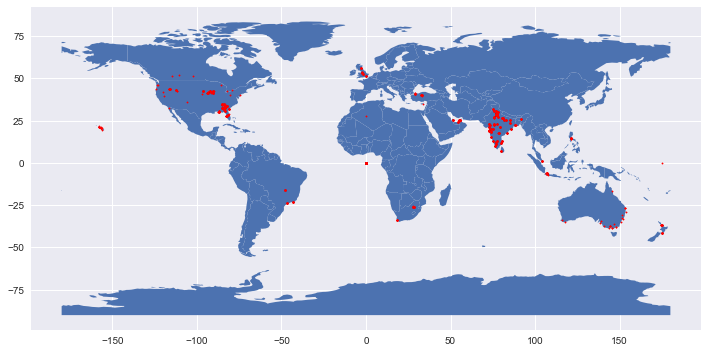

In [66]:
# Finally we saw the locations of the restaurants using its coordinates:
# We can visualize where these restaurants are located around the globe using
# its coordinates values

# To do so, we first zip longitude and latitud and saved as a new list, and 
# these values will be added to our dataframe as coordinates Points:
geometry = [Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]

# Then we create this GeoDataFrame that will allow us to plot coordinates in a map
gdf = GeoDataFrame(data, geometry=geometry)   
# We import a simple map from Geopandas, and plot together with the coordinates on top.
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(12, 6)), marker='o', color='red', markersize=2)